In [3]:
import Deck 
import PolicyH as Policy
import random
import Special_Deck as SDeck

""" 
USAGE: 
table = Deck.BlackJackEnv(5)
table.start_round()
table.next(0) 0 for stand, 1 for hit 2 for double down
Both start_round and next return: player hand, dealer hand, hasAce, roundStarted, reward, runningCount, hasDoubled
"""

' \nUSAGE: \ntable = Deck.BlackJackEnv(5)\ntable.start_round()\ntable.next(0) 0 for stand, 1 for hit 2 for double down\nBoth start_round and next return: player hand, dealer hand, hasAce, roundStarted, reward, runningCount, hasDoubled\n'

# Approach 1

The first approach is to incorporate the running count into the blackjack enviroment directly, and allow the q-learning agent to 'count-cards' by tracking the number of high and low counts which have exited the game (see deal_card() in deck.py). Since the running count can vary by integer amounts which leads to a very large amount of possible states, the running counts are grouped into 3 possible enviroment conditions (see get_rCount()): low count (few 10s left in deck), neutral count, and positive count (lots of 10s left in deck). 

The policy extracted from the q-learning therefore has 3 different policies for the 3 different rCount bins (and each of those 3 policies also consists of HasAce and noAce policies). A potential weakness of this approach is that by probability it is unlikely (and therefore not extremely common) for a deck to achieve a really low or high count, which means the agent will not visit those states nearly as much as neutral states in training. This will cause for more variance in the extracted policies. Approach 2 will specificly aim to solve this issue by training on decks with artificially high and low running counts. 

In [6]:

def q_solve(env, countCards):
    
    #ROWS REPRESENT PLAYER TOTALS: 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21 (18 total)
    #COLUMNS REPRESENT DEALER SHOWING: 2,3,4,5,6,7,8,9,10,11 (10 total)
    #HAS ACE: 0,1 (2 total)
    #RUNNING COUNT: 0,1,2 (3 total)
    #ACTION: HIT, STAY, DOUBLE (3 total)
    possible_moves = [0,1,2] 
    MOVES = ['S', 'H', 'D']
    r = 18
    c = 10
    
    #Initializing Qvals arr 
    qVals = [] # qvals[player][dealer][hasAce][rCount][action]
    for i in range(r):
        q_row = []
        for j in range(c):
            q_row.append([[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]],[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]]])
        
        qVals.append(q_row)
        
    #Learning
    for _ in range(ITERATIONS):
        
        # Round Start
        pl,dl,hasAce,_,reward,rCount,_ = env.start_round()
        #If we are not counting cards, rCount will always be 0, and only that part of qVals will be populated
        if not countCards:
            rCount = 0

        while True:
            #Break and update qvals if terminal state
            if reward != 0.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = reward
                qVals[pl-4][dl-2][hasAce][rCount][1] = reward
                qVals[pl-4][dl-2][hasAce][rCount][2] = reward
                break

            pr = random.random() #With prob EXPLORE_PROB we pick a random possible move, otherwise we pick best q
            action = 0
            if pr < EXPLORE_PROB:
                action = random.choice(possible_moves)
            else:
                best_action_q = max(qVals[pl-4][dl-2][hasAce][rCount])
                action = qVals[pl-4][dl-2][hasAce][rCount].index(best_action_q)

            pl_new,dl_new,hasAce_new,_,reward,rCount_new,doubled = env.next(action)

            if not countCards: #Also set rCount_new to 0 if not counting cards
                rCount_new = 0

            #calling new_q to update current q
            q = new_q(reward,hasAce,qVals,pl,dl,rCount,pl_new,dl_new,hasAce_new,rCount_new,action,doubled)
            qVals[pl-4][dl-2][hasAce][rCount][action] = q #Updating q in qvals arr
            
            #Break out of loop if new move caused terminal state
            if reward != 0.0:
                break
            #Moving on if not terminal state
            pl = pl_new
            dl= dl_new
            hasAce = hasAce_new
            rCount = rCount_new

    #Calls get_policy on the qVals arr to extract policy 
    return get_policy(qVals,countCards), qVals


#Q learning function -- approach followed from MDP HW Assignment
def new_q(action_reward,hasAce, qVals, pl_old, dl_old,rCount, pl_new, dl_new,hasAce_new,rCount_new, movenum,doubled):
   
    old_q = qVals[pl_old-4][dl_old-2][hasAce][rCount][movenum]
    #Accounting for terminal states
    if pl_new == 21:
        best_next_q = 200.0 if doubled else 100.0
    elif pl_new > 21:
        best_next_q = -200.0 if doubled else -100.0
    else:
        best_next_q = max(qVals[pl_new-4][dl_new-2][hasAce_new][rCount_new])

    new_q = old_q + LEARNING_RATE * (action_reward + DISCOUNT_FACTOR * best_next_q - old_q)

    return new_q

#Helper function to get extract policy from qvals -- different if countCards=true
def get_policy(qVals,countCards):
        MOVES = ['S', 'H', 'D']
        aces = []
        no_aces = []
        for count in range (0,3):
            ace_policy = []
            policy = []
            #Gets the best action for all possible dealer/player/rcount combinations
            #Gets policy for noAce and Ace cases
            for i in range(4, 22):
                ace_row = []
                row = []
                for j in range(2, 12):
                    best_action_index = qVals[i-4][j-2][0][count].index(max(qVals[i-4][j-2][0][count])) 
                    best_action = MOVES[best_action_index]
                    row.append(best_action)
                    best_action_index_ace = qVals[i-4][j-2][1][count].index(max(qVals[i-4][j-2][1][count])) 
                    best_action_ace = MOVES[best_action_index_ace]
                    ace_row.append(best_action_ace)
                policy.append(row)
                ace_policy.append(ace_row)
            aces.append(ace_policy)
            no_aces.append(policy)
            #Break early if not counting cards
            if not countCards:
                return (policy, ace_policy)

        

        return (no_aces, aces)

APPROACH 3: Artificially adjusting the decks and training on low/high count.

For this approach, we changed either removed or added 8 extra 10s.

The cell below trains on a deck with a low count:

Winrate:  0.421639
Tie rate:  0.0950685
Loss rate:  0.4832925
Average reward:  -2.5322825


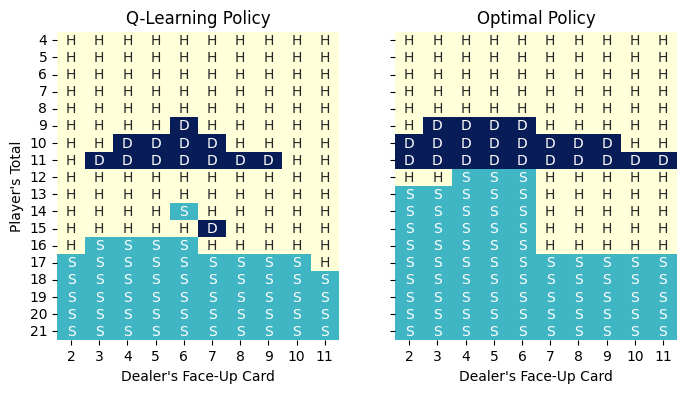

In [25]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.4
EXPLORE_PROB = 0.6 # for Q-learning
ITERATIONS = 4000000
Num_Decks = 2
table = SDeck.BlackJackEnv(Num_Decks,True)

(no_aces_low,aces_low),_ = q_solve(table,False)
winrate,tierate, lossrate, avg_reward = Policy.try_policy(no_aces_low,aces_low,False,Num_Decks)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
Policy.map_policies(no_aces_low,False)

The cell below trains on a high count

Winrate:  0.4317945
Tie rate:  0.0860625
Loss rate:  0.482143
Average reward:  -0.8575875


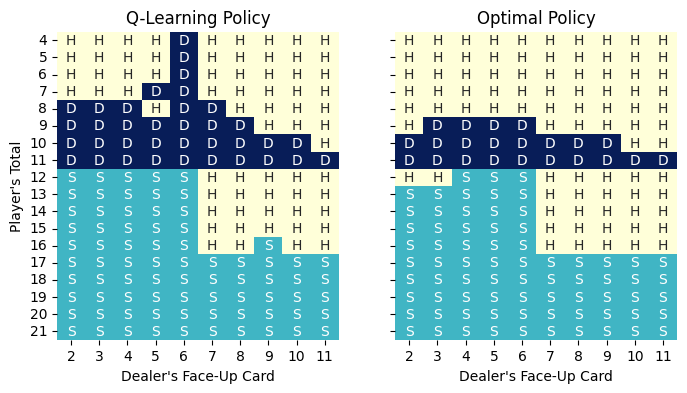

In [26]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.4
EXPLORE_PROB = 0.6 # for Q-learning
ITERATIONS = 4000000
Num_Decks = 2
table = SDeck.BlackJackEnv(Num_Decks,False)

(no_aces_high,aces_high),_ = q_solve(table,False)
winrate,tierate, lossrate, avg_reward = Policy.try_policy(no_aces_high,aces_high,False,Num_Decks)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
Policy.map_policies(no_aces_high,False)

The cell below trains on neutral count (regular deck - no counting)

Winrate:  0.4337535
Tie rate:  0.0858335
Loss rate:  0.480413
Average reward:  -0.4170075


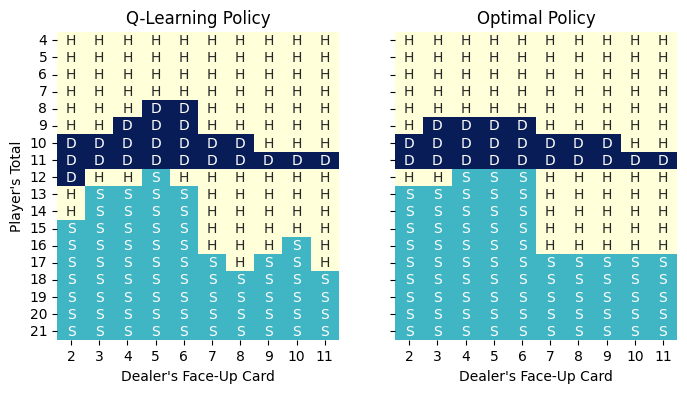

In [27]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.4
EXPLORE_PROB = 0.6 # for Q-learning
ITERATIONS = 4000000
Num_Decks = 2
table = Deck.BlackJackEnv(Num_Decks,1.0)

(no_aces,aces),_ = q_solve(table,False)
winrate,tierate, lossrate, avg_reward = Policy.try_policy(no_aces,aces,False,Num_Decks)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
Policy.map_policies(no_aces,False)

Now, we will combine the different policies extracted and combine them to try the policy on a regular deck:


Winrate:  0.434008
Tie rate:  0.0863505
Loss rate:  0.4796415
Average reward:  -0.2800475


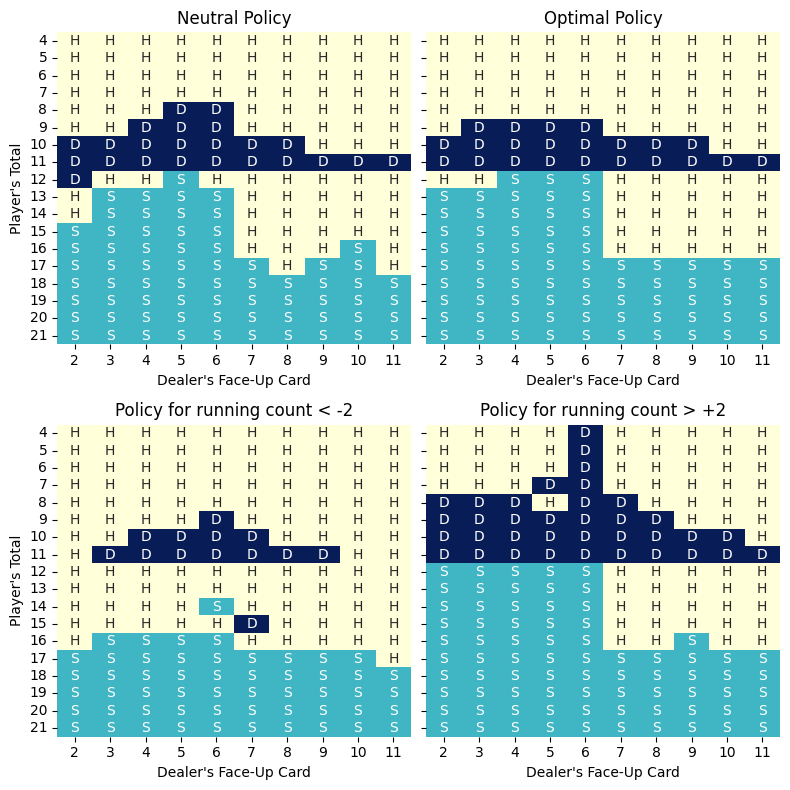

In [28]:
combined_no_aces = []
combined_no_aces.append(no_aces_low)
combined_no_aces.append(no_aces)
combined_no_aces.append(no_aces_high)

combined_aces = []
combined_aces.append(aces_low)
combined_aces.append(aces)
combined_aces.append(aces_high)


winrate,tierate, lossrate, avg_reward = Policy.try_policy(combined_no_aces,combined_aces,True,Num_Decks)
print("Winrate: ", winrate)
print("Tie rate: ", tierate)
print("Loss rate: ", lossrate)
print("Average reward: ", avg_reward)
Policy.map_policies(combined_no_aces,True)